In [1]:
import re    
import nltk
import string 
import warnings 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import gensim as gensim
import warnings
warnings.filterwarnings("ignore")

# 1. Loading Dataset

In [4]:
#Load the dataset named'train.csv' which we will be using to train and validate the models. 
train_df = pd.read_csv('train.csv')
#This file is provided for submission purposes but we will use this in understanding the tweets and generating features. 
test_df = pd.read_csv('test.csv')

#Lets look at few records in the training dataset. 
train_df.head()


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [575]:
print('Training dataset is of shape {} '.format(train_df.shape))
print('Testing dataset is of shape {} '.format(test_df.shape))

train_df.head()

Training dataset is of shape (31962, 3) 
Testing dataset is of shape (17197, 2) 


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Manually defined list of google stop words.

stop words are most commonly used words, we will ignore these words because they can skew our calculations when we are trying to find certain key words that are indicative of racist vs non-racist tweets

In [576]:
    stop_word_list = ['a','about','above','across','after','again','against','all','almost','alone','along','already','also',
    'although','always','among','an','and','another','any','anybody','anyone','anything','anywhere','are','area','areas',
    'around','as','ask','asked','asking','asks','at','away','b','back','backed','backing','backs','be','became','because','become',
    'becomes','been','before','began','behind','being','beings','best','better','between','big','both','but','by','c','came',
    'can','cannot','case','cases','certain','certainly','clear','clearly','come','could','d','did','differ','different','differently',
    'do','does','done','down','down','downed','downing','downs','during','e','each','early','either','end','ended','ending',
    'ends','enough','even','evenly','ever','every','everybody','everyone','everything','everywhere','f','face','faces','fact',
    'facts','far','felt','few','find','finds','first','for','four','from','full','fully','further','furthered','furthering',
    'furthers','g','gave','general','generally','get','gets','give','given','gives','go','going','good','goods','got','great','greater',
    'greatest','group','grouped','grouping','groups','h','had','has','have','having','he','her','here','herself','high','high',
    'high','higher','highest','him','himself','his','how','however','i','if','important','in','interest','interested','interesting','interests',
    'into','is','it','its','itself','j','just','k','keep','keeps','kind','knew','know','known','knows','l','large','largely','last',
    'later','latest','least','less','let','lets','like','likely','long','longer','longest','m','made','make','making','man','many',
    'may','me','member','members','men','might','more','most','mostly','mr','mrs','much','must','my','myself','n','necessary',
    'need','needed','needing','needs','never','new','new','newer','newest','who','whole','whose','why','will','with','within',
    'without','work','worked','working','works','would','x','y','year','years','yet','you','young','younger','youngest','your',
    'yours','z']
    
    print(stop_word_list)

['a', 'about', 'above', 'across', 'after', 'again', 'against', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'among', 'an', 'and', 'another', 'any', 'anybody', 'anyone', 'anything', 'anywhere', 'are', 'area', 'areas', 'around', 'as', 'ask', 'asked', 'asking', 'asks', 'at', 'away', 'b', 'back', 'backed', 'backing', 'backs', 'be', 'became', 'because', 'become', 'becomes', 'been', 'before', 'began', 'behind', 'being', 'beings', 'best', 'better', 'between', 'big', 'both', 'but', 'by', 'c', 'came', 'can', 'cannot', 'case', 'cases', 'certain', 'certainly', 'clear', 'clearly', 'come', 'could', 'd', 'did', 'differ', 'different', 'differently', 'do', 'does', 'done', 'down', 'down', 'downed', 'downing', 'downs', 'during', 'e', 'each', 'early', 'either', 'end', 'ended', 'ending', 'ends', 'enough', 'even', 'evenly', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'f', 'face', 'faces', 'fact', 'facts', 'far', 'felt', 'few', 'find', 'finds', 'first

# 2. Data inspection

check the distribution of data in training dataset

In [577]:
train_df["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

So, ~93% of data is labelled as non racists tweets.

   Lets check for any missing data in both training and testing datasets.If there are rows with missing information we will remove them. 

In [578]:
print('In training data :')
print('number of missing labels :',train_df['label'].isnull().sum())
print('number of missing tweets :',train_df['tweet'].isnull().sum())

print('In testing data :')
print('number of missing labels :',test_df['tweet'].isnull().sum())


In training data :
number of missing labels : 0
number of missing tweets : 0
In testing data :
number of missing labels : 0


   There is no missing information, 
   
   lets check few racist tweets

In [579]:
(train_df[train_df['label'] == 1]).head(5)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


  Few non-Racist tweets

In [580]:
(train_df[train_df['label'] == 0]).head(5)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Lets check the distribution of length of the tweets, in terms of words, in both train and test data.

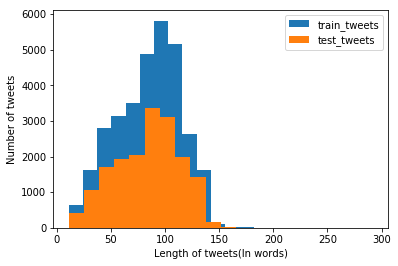

In [8]:
length_train = train_df['tweet'].str.len() 
length_test = test_df['tweet'].str.len() 
plt.hist(length_train, bins=20, label="train_tweets") 
plt.hist(length_test, bins=20, label="test_tweets") 
plt.legend()
plt.xlabel('Length of tweets(In words)')
plt.ylabel('Number of tweets')
plt.show()

# 3. Data cleaning

We will be following the steps below to clean the tweets.

1. Remove the twitter handles. These twitter handles hardly give any information about the nature of the tweet. Handles here are '@user'. 

2. we will stem the  data. For example, reducing terms like loves, loving, and lovable to their base word, i.e., ‘love’.are often used in the same context.

3. We will also get rid of the punctuations, numbers and even special characters since they wouldn’t help in differentiating different types of tweets except # to identify hashtags

4. we'll remove short words

5. we will remove stop words.

 
To do that we will merge the train and test tweets so that we can apply cleaning on entire data and generate better features to train model.Later we will again split them into train and test datasets. 

In [582]:
merged_data = train_df.append(test_df,ignore_index=True,sort=False)
merged_data.shape


(49159, 3)

1. Remove twitter handles. only handle we have is @user but we will use a regex which strips off any twitter handle. 

In [583]:
merged_data['clean_tweet'] = merged_data['tweet'].str.replace("@[\w]*", "")
merged_data.head(5)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


2. Removing punctuations

In [584]:
merged_data['clean_tweet'] = merged_data['clean_tweet'].str.replace("[^a-zA-Z#]", " ") 
merged_data.head(5)

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


In [585]:
merged_data['clean_tweet'] = merged_data['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
merged_data.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


3. Stemming the data

In [664]:
tokenized_tweet = merged_data['clean_tweet'].apply(lambda x: x.split())

from gensim.parsing.porter import PorterStemmer
stemmer = PorterStemmer() 

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

tokenized_tweet.head(5)

0    [when, father, dysfunct, selfish, drag, into, ...
1    [thank, #lyft, credit, cau, thei, offer, wheel...
2                              [bihdai, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: clean_tweet, dtype: object

In [665]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 

merged_data['clean_tweet'] = tokenized_tweet

merged_data.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag into dysfunc...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit cau thei offer wheelchair #...
2,3,0.0,bihday your majesty,bihdai your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


4. Removing short words

In [663]:
merged_data['clean_tweet'] = merged_data['clean_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
merged_data.head()

,id,label,tweet,clean_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunct selfish drag into dysfunc...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit caus thei offer wheelchair ...
2,3,0.0,bihday your majesty,bihdai your majesti
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguid societi #motiv


# 4. Visualization words using wordcloud

### 4.1. visualize all words

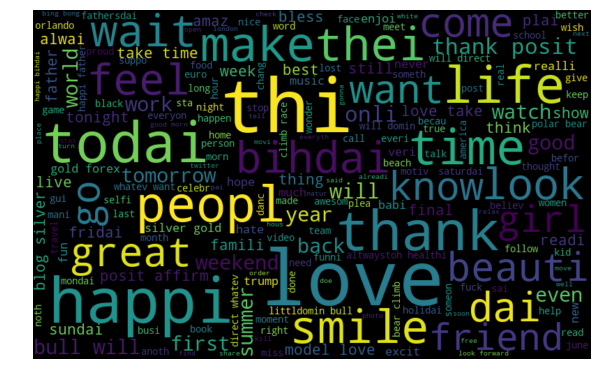

In [589]:
from wordcloud import WordCloud

words = ' '.join([text for text in merged_data['clean_tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### 4.2 visualize only Non racist words 

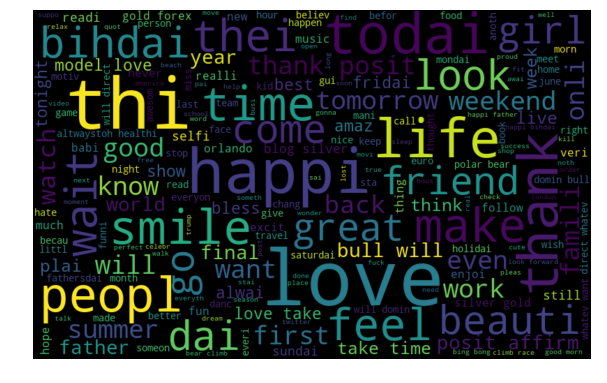

In [590]:
words = ' '.join([text for text in merged_data['clean_tweet'][merged_data['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

### 4.3 only racist words 

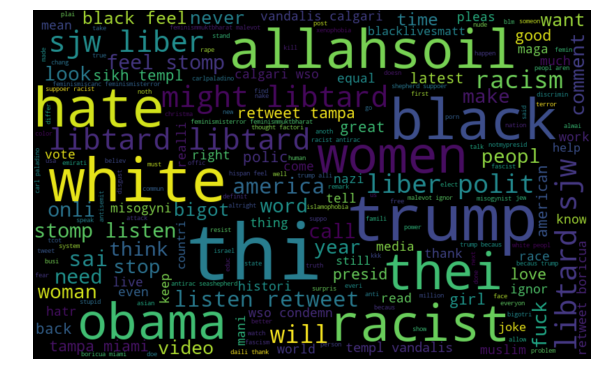

In [591]:
words = ' '.join([text for text in merged_data['clean_tweet'][merged_data['label'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words) 
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

# 5. Feature generation

### 5.1 Bag of words features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(stop_words=stop_word_list, max_features=1000)

In [651]:
bow = count_vector.fit_transform(merged_data['clean_tweet']).toarray()
bow_features = count_vector.get_feature_names()
frequency_matrix = pd.DataFrame(bow,columns=bow_features)
frequency_matrix.head()

,abl,absolut,accept,account,act,action,activ,actor,actual,adapt,...,xxx,yai,yeah,yesterdai,yoga,york,yourself,youth,youtub,yummi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [653]:
# Lets see the features generated by BOW
bow_features

['abl',
 'absolut',
 'accept',
 'account',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'adapt',
 'adult',
 'adventur',
 'affirm',
 'afternoon',
 'agre',
 'ahead',
 'aist',
 'album',
 'aliv',
 'allahsoil',
 'allig',
 'allow',
 'alon',
 'alreadi',
 'altwaystoh',
 'alwai',
 'amaz',
 'america',
 'american',
 'angel',
 'anger',
 'angri',
 'anim',
 'anniversari',
 'announc',
 'anoth',
 'answer',
 'anti',
 'anxieti',
 'anymor',
 'anyon',
 'anyth',
 'app',
 'appl',
 'appreci',
 'aren',
 'arriv',
 'attack',
 'august',
 'avail',
 'awai',
 'award',
 'awesom',
 'babe',
 'babi',
 'balanc',
 'ball',
 'bank',
 'bdai',
 'beach',
 'bear',
 'beat',
 'beauti',
 'becaus',
 'becom',
 'beer',
 'befor',
 'begin',
 'behappi',
 'believ',
 'below',
 'benefit',
 'bestfriend',
 'besti',
 'bigot',
 'bihdai',
 'bike',
 'bill',
 'bing',
 'bird',
 'bitch',
 'black',
 'blame',
 'bless',
 'blm',
 'block',
 'blog',
 'blogger',
 'blond',
 'blue',
 'blur',
 'board',
 'bodi',
 'boi',
 'bong',
 'book',
 'bore',
 'bor

### 5.2. TDIDF features

In [594]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector = TfidfVectorizer(max_df=0.90, min_df=2, stop_words=stop_word_list, max_features=1000)
# TF-IDF feature matrix
tfidf_bow = tfidf_vector.fit_transform(merged_data['clean_tweet']).toarray()
tfidf_features = tfidf_vector.get_feature_names()

frequency_matrix = pd.DataFrame(tfidf_bow,columns=tfidf_features)
frequency_matrix.head()

,abl,absolut,accept,account,act,action,activ,actor,actual,adapt,...,xxx,yai,yeah,yesterdai,yoga,york,yourself,youth,youtub,yummi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [654]:
# Lets see the features generated by TFIDF
tfidf_features

['abl',
 'absolut',
 'accept',
 'account',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'adapt',
 'adult',
 'adventur',
 'affirm',
 'afternoon',
 'agre',
 'ahead',
 'aist',
 'album',
 'aliv',
 'allahsoil',
 'allig',
 'allow',
 'alon',
 'alreadi',
 'altwaystoh',
 'alwai',
 'amaz',
 'america',
 'american',
 'angel',
 'anger',
 'angri',
 'anim',
 'anniversari',
 'announc',
 'anoth',
 'answer',
 'anti',
 'anxieti',
 'anymor',
 'anyon',
 'anyth',
 'app',
 'appl',
 'appreci',
 'aren',
 'arriv',
 'attack',
 'august',
 'avail',
 'awai',
 'award',
 'awesom',
 'babe',
 'babi',
 'balanc',
 'ball',
 'bank',
 'bdai',
 'beach',
 'bear',
 'beat',
 'beauti',
 'becaus',
 'becom',
 'beer',
 'befor',
 'begin',
 'behappi',
 'believ',
 'below',
 'benefit',
 'bestfriend',
 'besti',
 'bigot',
 'bihdai',
 'bike',
 'bill',
 'bing',
 'bird',
 'bitch',
 'black',
 'blame',
 'bless',
 'blm',
 'block',
 'blog',
 'blogger',
 'blond',
 'blue',
 'blur',
 'board',
 'bodi',
 'boi',
 'bong',
 'book',
 'bore',
 'bor

### 5.3. Word2Vec features

Word2Vec helps is a way of representing words in vectors and helps in dimensionality reduction by finding contextual similarity between words.For example given a context of words like King-man+women it can say that we meant "Queen"

Let us generate some 200 features using Word2Vec

In [596]:
tokenized_tweet = merged_data['clean_tweet'].apply(lambda x: x.split())
model = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34) 

In [598]:
model.train(tokenized_tweet, total_examples= len(merged_data['clean_tweet']), epochs=20)

(6510046, 7535460)

Lets check some words to see if it got the context correctly. 

In [599]:
model.wv.most_similar(positive="dinner")

[('#biall', 0.4989904761314392),
 ('#bihdaydinn', 0.47030818462371826),
 ('noodl', 0.46777278184890747),
 ('lukei', 0.4603480100631714),
 ('#foodcoma', 0.4582524597644806),
 ('#burrito', 0.4531261920928955),
 ('canni', 0.45033395290374756),
 ('alfredo', 0.4497165083885193),
 ('mansion', 0.4488169252872467),
 ('spaghetti', 0.4433712959289551)]

In [600]:
model.wv.most_similar(positive="trump")

[('phoni', 0.5323117971420288),
 ('donald', 0.5306750535964966),
 ('tomlin', 0.5064955949783325),
 ('hillari', 0.5044801831245422),
 ('chopra', 0.5034595727920532),
 ('businessman', 0.5023002624511719),
 ('jibe', 0.49191367626190186),
 ('cower', 0.48609432578086853),
 ('truism', 0.4844127297401428),
 ('unfavor', 0.4823035001754761)]

we will create vector representation for all our tweets. 
For this, we will take mean of all the word vectors present in the tweet.

In [601]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size))
            count += 1.
        except KeyError:                                     
            continue
    if count != 0:
        vec /= count
    return vec

In [634]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    wordvec_df = pd.DataFrame(wordvec_arrays) 


# 6. Model Evaluation

Alogithms to be trained

    1. Logistic Regression
    2. Naive Bayes
    3. Random Forest
    4. XGBoost

In [603]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

rf = RandomForestClassifier()
nb = MultinomialNB()
lreg = LogisticRegression()
xg = XGBClassifier()

# Helper method to print scores
def report_scores(model, predictions):
        print('Accuracy score of {} model is {} '.format(model, accuracy_score(predictions,y_test)))
        print('Precision score of {} model is {} '.format(model, precision_score(predictions,y_test)))
        print('Recall score of {} model is {} '.format(model, recall_score(predictions,y_test)))
        print('F1 score of {} model is {} \n\n '.format(model, f1_score(predictions,y_test)))

# Helper method to run modelling
def run_modeling(models):
       
    for model,name in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        report_scores(name, predictions)
        
def split_data(data):
    return train_test_split(data,train_df['label'],random_state=1, test_size=0.3)

### 6.1. using bag of words features

In [604]:
# prepare training and testing data with bag of words features
data = bow[:31962,:]

X_train, X_test, y_train, y_test = split_data(data)

print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the training set: 22373
Number of rows in the test set: 9589


In [605]:
#models to run on
models = {rf:'Random Forest',xg:'xgboost', nb:'Naive bayes', lreg:'Logistic Regression'}

#Run the model with bag of words fetures
run_modeling(models)

Accuracy score of Random Forest model is 0.9384711648764209 
Precision score of Random Forest model is 0.4884437596302003 
Recall score of Random Forest model is 0.551304347826087 
F1 score of Random Forest model is 0.5179738562091503 

 
Accuracy score of xgboost model is 0.944936906872458 
Precision score of xgboost model is 0.21263482280431434 
Recall score of xgboost model is 0.8903225806451613 
F1 score of xgboost model is 0.3432835820895523 

 
Accuracy score of Naive bayes model is 0.9341954322661383 
Precision score of Naive bayes model is 0.5130970724191063 
Recall score of Naive bayes model is 0.5138888888888888 
F1 score of Naive bayes model is 0.5134926754047803 

 
Accuracy score of Logistic Regression model is 0.9492126394827406 
Precision score of Logistic Regression model is 0.3682588597842835 
Recall score of Logistic Regression model is 0.7563291139240507 
F1 score of Logistic Regression model is 0.49533678756476685 

 


### 6.2. using TFIDF features

In [606]:
train = tfidf_bow[:31962,:]

X_train, X_test, y_train, y_test = split_data(data)

print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the training set: 22373
Number of rows in the test set: 9589


In [607]:
#models to run on
models = {rf:'Random Forest',xg:'xgboost', nb:'Naive bayes', lreg:'Logistic Regression'}

#Run the model with TFIDF features
run_modeling(models)

Accuracy score of Random Forest model is 0.9393054541662321 
Precision score of Random Forest model is 0.5007704160246533 
Recall score of Random Forest model is 0.5574614065180102 
F1 score of Random Forest model is 0.5275974025974026 

 
Accuracy score of xgboost model is 0.944936906872458 
Precision score of xgboost model is 0.21263482280431434 
Recall score of xgboost model is 0.8903225806451613 
F1 score of xgboost model is 0.3432835820895523 

 
Accuracy score of Naive bayes model is 0.9341954322661383 
Precision score of Naive bayes model is 0.5130970724191063 
Recall score of Naive bayes model is 0.5138888888888888 
F1 score of Naive bayes model is 0.5134926754047803 

 
Accuracy score of Logistic Regression model is 0.9492126394827406 
Precision score of Logistic Regression model is 0.3682588597842835 
Recall score of Logistic Regression model is 0.7563291139240507 
F1 score of Logistic Regression model is 0.49533678756476685 

 


### 6.3.  using word2Vec features

In [608]:
data = wordvec_df.iloc[:31962,:]

X_train, X_test, y_train, y_test = split_data(data)

print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the training set: 22373
Number of rows in the test set: 9589


In [609]:
#models to run on
models = {rf:'Random Forest',xg:'xgboost', lreg:'Logistic Regression'}

#Run the model with TFIDF features
run_modeling(models)

Accuracy score of Random Forest model is 0.9527583689644384 
Precision score of Random Forest model is 0.35285053929121724 
Recall score of Random Forest model is 0.8740458015267175 
F1 score of Random Forest model is 0.5027442371020856 

 
Accuracy score of xgboost model is 0.953175513609344 
Precision score of xgboost model is 0.4036979969183359 
Recall score of xgboost model is 0.808641975308642 
F1 score of xgboost model is 0.538540596094553 

 
Accuracy score of Logistic Regression model is 0.9530712274481177 
Precision score of Logistic Regression model is 0.4699537750385208 
Recall score of Logistic Regression model is 0.7420924574209246 
F1 score of Logistic Regression model is 0.5754716981132075 

 


In [660]:
# Lets create a dataframe using the F1 scores we got from the training to better vizaualize the results. 
df = pd.DataFrame({'bow': [52.7,34.3,51.5,49.5], 'tfdif': [52.7,34.3,51.3,49.5],'word2vec':[50.2,53.8,0.0,57.5]},index = ['rf', 'xg', 'nb','lg'])

df['avg'] = df1.mean(axis=1)

df.head()

,bow,tfdif,word2vec,avg
rf,52.7,52.7,50.2,51.466667
xg,34.3,34.3,53.8,40.900000
nb,51.5,51.3,0.0,33.466667
lg,49.5,49.5,57.5,47.533333


our best model is logistic regression model with word2Vec features. 

we will tune the model to improve the performance of the model. 

# 7. Hyperparameter tuning

In [635]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
    
tfidf_train = tfidf_bow[:31962,:]
bow_train = bow[:31962,:]
wordvec_train = wordvec_df.iloc[:31962,:]

def run_tuning(data):
    X_train, X_test, y_train, y_test = split_data(data)

    parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter':[100,200,300,400,500], 'solver':['warn']}

    clf = lreg

    #Make an fbeta_score scoring object using make_scorer()
    scorer = make_scorer(fbeta_score,beta=0.5)

    # Performing grid search on the classifier using 'scorer' as the scoring method
    grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

    grid_fit = grid_obj.fit(X_train, y_train)

    best_clf = grid_fit.best_estimator_
    print(best_clf)

    # Make predictions using the unoptimized and model
    best_predictions = best_clf.predict(X_test)
    
    report_scores("LogisticRegression", best_predictions)

In [641]:
#Lets run the tuning on bow features
run_tuning(bow_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy score of LogisticRegression model is 0.9492126394827406 
Precision score of LogisticRegression model is 0.3682588597842835 
Recall score of LogisticRegression model is 0.7563291139240507 
F1 score of LogisticRegression model is 0.49533678756476685 

 


Lets see which features are considered important in the bag of word features 

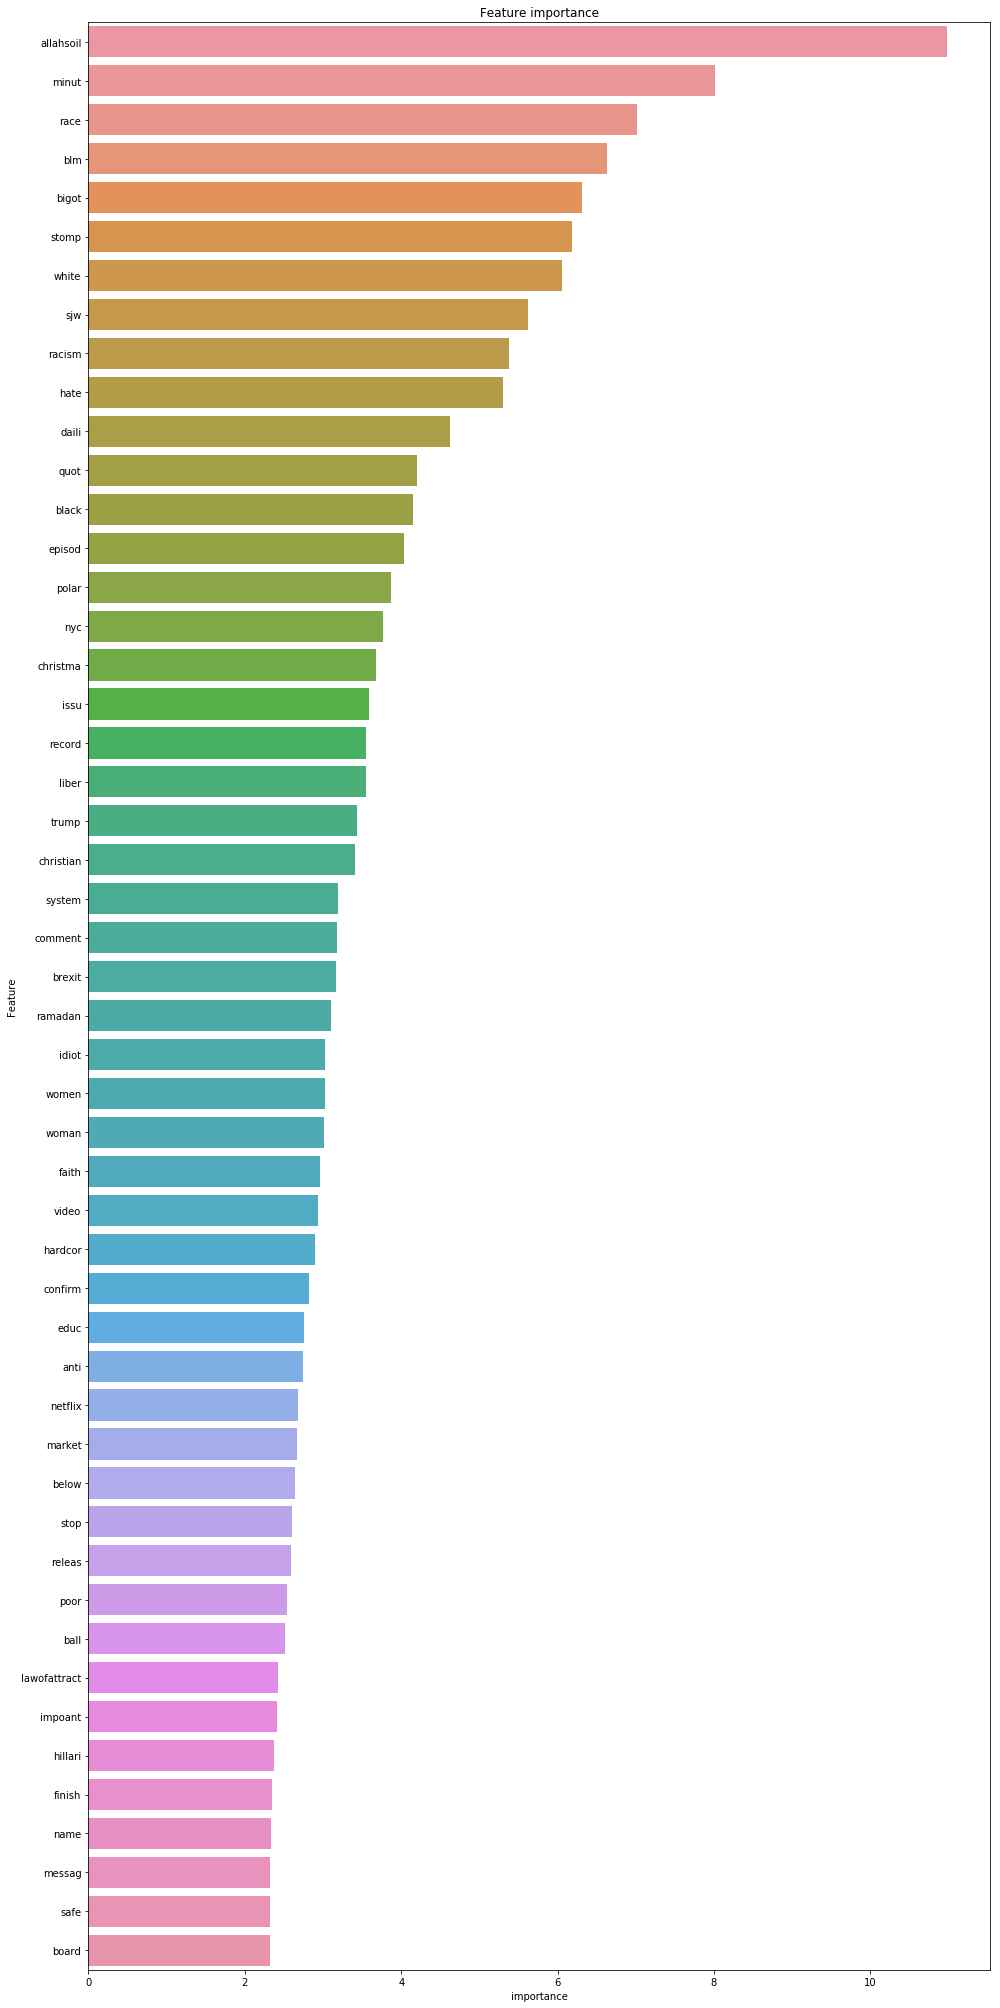

In [658]:
# plot important features in bow

feature_importance_df = pd.DataFrame()

coeff_list = np.ndarray.tolist(best_clf.coef_[0])

for feature, importance in zip(bow_features, coeff_list):
    feature_importance_df = feature_importance_df.append({'Feature': feature, 'importance':importance}, ignore_index=True)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Feature importance')
plt.tight_layout()

In [637]:
#Lets run the tuning on tfidf features
run_tuning(tfidf_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy score of LogisticRegression model is 0.9499426426113254 
Precision score of LogisticRegression model is 0.41448382126348227 
Recall score of LogisticRegression model is 0.7289972899728997 
F1 score of LogisticRegression model is 0.5284872298624754 

 


Lets see which features are considered important in the TFIDF features:

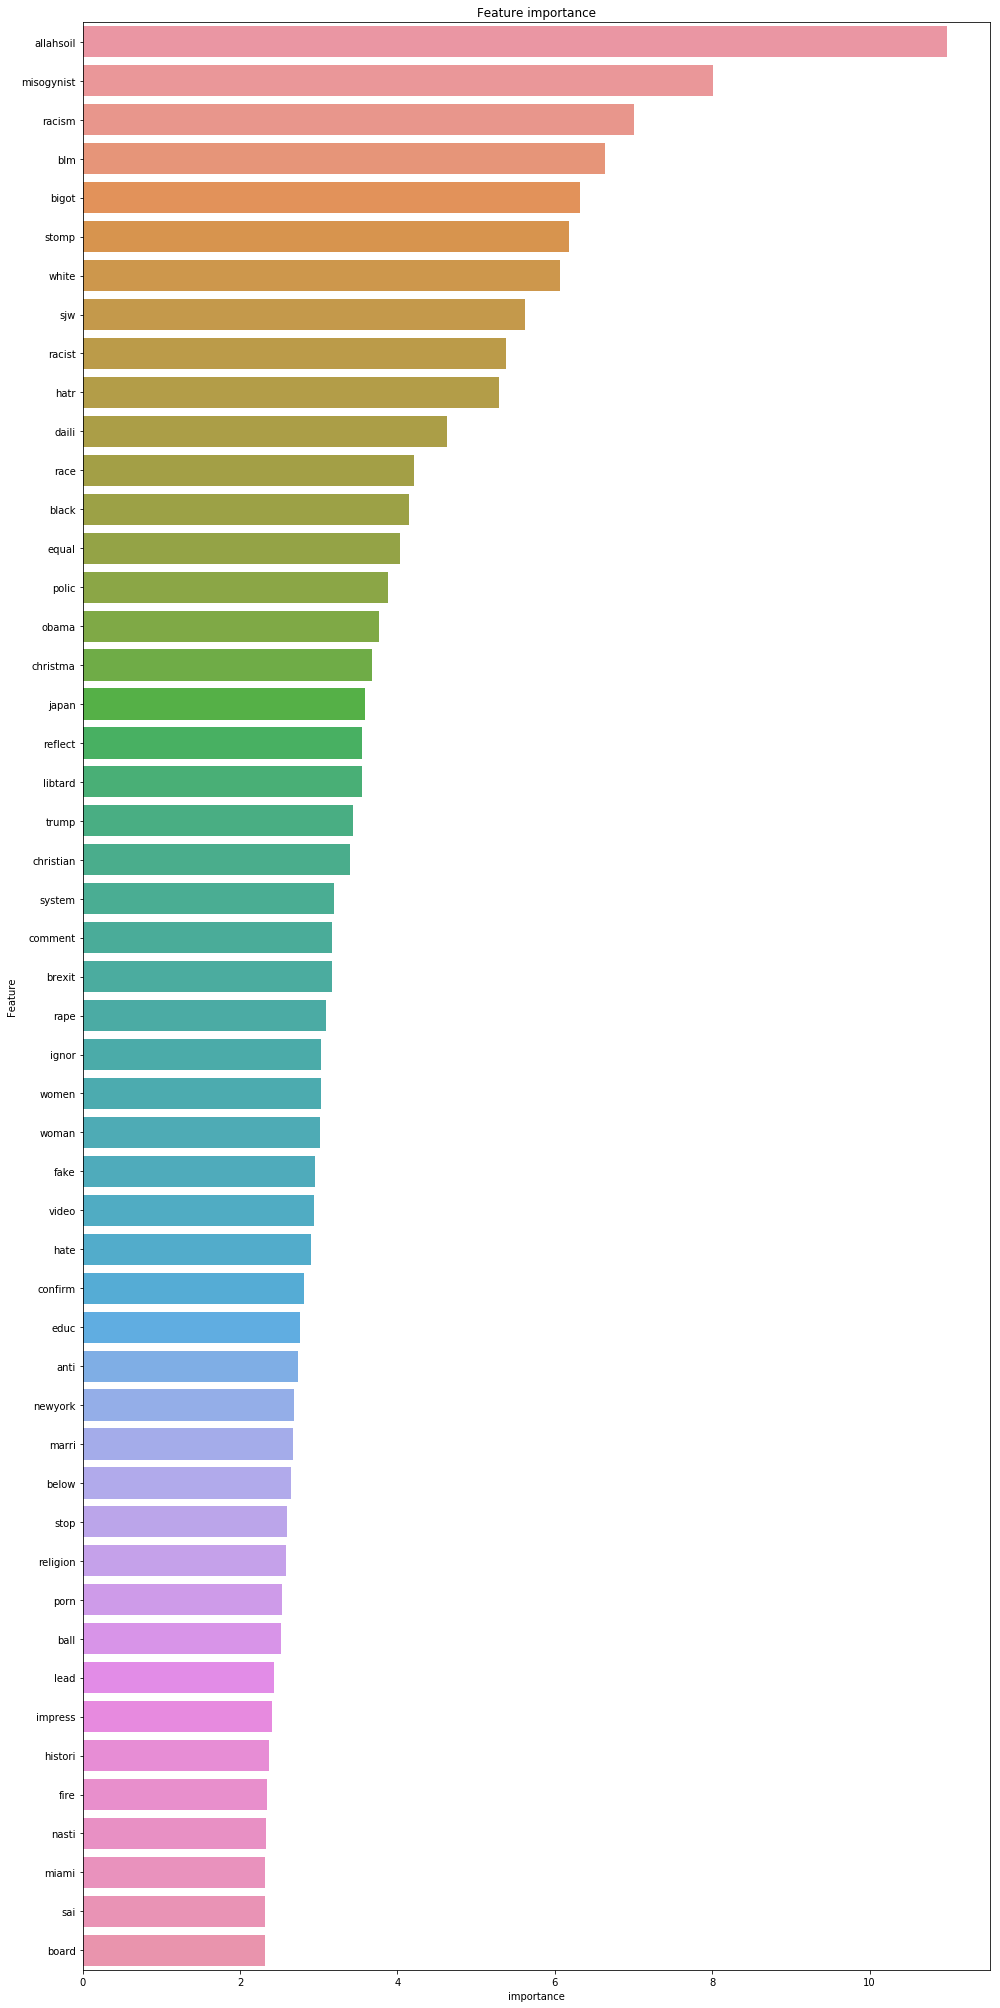

In [659]:
feature_importance_df = pd.DataFrame()

coeff_list = np.ndarray.tolist(best_clf.coef_[0])

for feature, importance in zip(tfidf_features, coeff_list):
    feature_importance_df = feature_importance_df.append({'Feature': feature, 'importance':importance}, ignore_index=True)

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:50].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Feature importance')
plt.tight_layout()

In [666]:
# Lets run the tuning on wordvec features
run_tuning(wordvec_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Accuracy score of LogisticRegression model is 0.9528626551256648 
Precision score of LogisticRegression model is 0.4761171032357473 
Recall score of LogisticRegression model is 0.7339667458432304 
F1 score of LogisticRegression model is 0.5775700934579439 

 


We can see there is a difference in what are considered are important features in BOW VS TDIDF. 

At a quick glance at the top 5 features, the 2nd feature in different in BOW VS TDIDF. But more or less these two feature sets concur on what is considered as an important feature. 

# 8. Conclusion

The best model is Logistic Regression model with Word2Vec features

F1 score of this model is 57.75. 